In [1]:
import pandas as pd 
import scanpy as sc
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# read 2n thyrcoytes
Th_adata = sc.read('../workingObj/Th_cThy.h5ad')

In [3]:
# read 'normal' adatas
Ho_adata = sc.read('../workingObj/Hong_2023_cThy.h5ad')
Pu_adata = sc.read('../workingObj/Pu_2021_cThy.h5ad')
Wa_adata = sc.read('../workingObj/Wang_2022_cThy.h5ad')
Lu_adata = sc.read('../workingObj/Lu_2023_cThy.h5ad')
Mo_adata = sc.read('../workingObj/Mosteiro_2023_cThy.h5ad')

In [4]:
adatas = {'Th_adata' : Th_adata,
          'Ho_adata' : Ho_adata,
          'Pu_adata' : Pu_adata,
          'Wa_adata' : Wa_adata,
          'Lu_adata' : Lu_adata,
          'Mo_adata' : Mo_adata}
len(adatas)

6

In [5]:
shared_genes = adatas['Th_adata'].var_names
for k, v in adatas.items():
    shared_genes = list(set(shared_genes) & set(v.var_names))
print(f'shared_genes: {len(shared_genes)}')

for k, v in adatas.items():
    adatas[k] = v[:,shared_genes]

shared_genes: 15392


In [6]:
# subset Th data for fTFC1 and fTFC2 only
temp = adatas['Th_adata']
adatas['Th_adata'] = temp[temp.obs['celltype'].isin(['thy_TH_processing', 'thy_Lumen-forming'])]

In [7]:
def HVG(adata):
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='counts', n_top_genes=2000, subset=False)
    highly_variable_genes  = adata.var_names[adata.var["highly_variable"]]
    return highly_variable_genes

In [8]:
HVG_shared = HVG(adatas['Th_adata'])
for k, v in adatas.items():
    HVG_shared = list(set(HVG_shared) & set(HVG(v)))
print(f'HVG_shared: {len(HVG_shared)}')

HVG_shared: 238


In [9]:
#Subseting the datasets
adatas_HVG = {}
for k, v in adatas.items():
    adatas_HVG[f'{k}_HVG'] = v[:,sorted(HVG_shared)]
for k, v in adatas_HVG.items():
    print(f'{k} : {v.shape}')

Th_adata_HVG : (40718, 238)
Ho_adata_HVG : (19131, 238)
Pu_adata_HVG : (6024, 238)
Wa_adata_HVG : (1646, 238)
Lu_adata_HVG : (754, 238)
Mo_adata_HVG : (17792, 238)


In [10]:
adatas_HVG['Th_adata_HVG'].obs['celltype'].value_counts()

thy_TH_processing    28998
thy_Lumen-forming    11720
Name: celltype, dtype: int64

In [11]:
adatas_HVG.keys()

dict_keys(['Th_adata_HVG', 'Ho_adata_HVG', 'Pu_adata_HVG', 'Wa_adata_HVG', 'Lu_adata_HVG', 'Mo_adata_HVG'])

In [12]:
# LoR
col = 'celltype'
celltypes_train = adatas_HVG['Th_adata_HVG'].obs[col]

%time
# training a logistic regression model on scRNA-seq data
logisticRegr_sc = LogisticRegression(max_iter = 5000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr_sc.fit(adatas_HVG['Th_adata_HVG'].X, celltypes_train)

# # save model
# with open('../workingObj/Th_LoR_model_shared_genes.pkl', 'wb') as file:  
#     pickle.dump(logisticRegr_sc, file)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 16.2 µs


LogisticRegression(C=0.2, max_iter=5000, n_jobs=-1, random_state=0)

In [13]:
cols = ['celltype_predictions', 'thy_Lumen-forming_prop', 'thy_TH_processing_prop', 'normDiff', 'combined_score','combined_score01']
# cols = ['celltype_predictions', 'thy_Top_edge_prop', 'thy_Bottom_edge_prop', 'normDiff', 'combined_score']
Th_adata_HVG = adatas_HVG.pop("Th_adata_HVG")
Th_adata = adatas.pop("Th_adata")

for k, v in adatas_HVG.items():
    print(f'{k}')
#     adatas_HVG[k] = predict(v, logisticRegr_sc)
    adatas_HVG[k].obs.index = v.obs.index.rename('Index')
    predictions = logisticRegr_sc.predict(v.X)
    adatas_HVG[k].obs['celltype_predictions'] = predictions

    # probabilities
    probabilities = logisticRegr_sc.predict_proba(v.X, )
    
    # calc normDiff add labels
    dd = pd.DataFrame(probabilities, columns=list(logisticRegr_sc.classes_ + '_prop'))
    dd['normDiff'] = (dd['thy_Lumen-forming_prop'] - dd['thy_TH_processing_prop']) / (dd['thy_Lumen-forming_prop'] + dd['thy_TH_processing_prop'])
    adatas_HVG[k].obs = pd.concat([v.obs.reset_index(drop=False), dd.reset_index(drop=True)], axis=1).set_index('Index')
    
    # calc scoreDiff add labels
#     adatas_HVG[k].obs['scoreDiff'] = adatas_HVG[k].obs['thy_Lumen-forming_prop'] - adatas_HVG[k].obs['thy_TH_processing_prop']

    # calc Log Odds Ratio add labels_cs
    score_A = v.obs['thy_Lumen-forming_prop']
    score_B = v.obs['thy_TH_processing_prop']
    log_odds_A = np.log(score_A / (1 - score_A))
    log_odds_B = np.log(score_B / (1 - score_B))
    combined_score = log_odds_A - log_odds_B
    adatas_HVG[k].obs['combined_score'] = combined_score
    adatas_HVG[k].obs['combined_score01'] = ((combined_score - combined_score.min())/(combined_score.max() - combined_score.min())) * 2 -1 #scale values to -1 and 1
    
    # add information to all data
    new_var = k.rsplit("_",1)[0]
    adatas[new_var].obs = pd.concat([adatas[new_var].obs, v.obs[cols]], axis=1)

Ho_adata_HVG
Pu_adata_HVG
Wa_adata_HVG
Lu_adata_HVG
Mo_adata_HVG


In [14]:
titles = {'Lu_adata' : 'Lu et al. 2023',
          'Ho_adata' : 'Hong et al. 2023',
          'Pu_adata' : 'Pu et al. 2021',
          'Wa_adata' : 'Wang et al. 2022',
          'Mo_adata' : 'Mosteiro et al. 2023'}

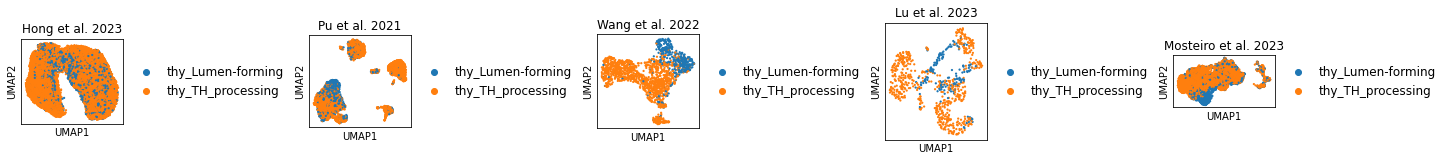

In [15]:
s = 20
axes = len(adatas.keys())
fig, axs = plt.subplots(1,axes, figsize=(20,5),constrained_layout=True, subplot_kw=dict(aspect='equal'))
for k, ax in zip(adatas.keys(), axs):
    sc.pl.umap(adatas[k], color=["celltype_predictions"],legend_fontsize='large',ax=ax, show=False, s=s, title=titles[k])

In [16]:
import numpy as np
from matplotlib import colors as mcolors

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

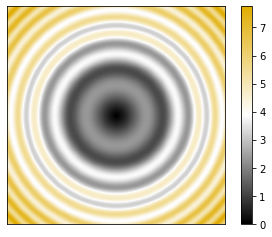

In [17]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ['#000000','#FFFFFF','#E1AD01']

fig, ax = plt.subplots(1,1)
im = ax.imshow(z, cmap=get_continuous_cmap(hex_list))
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

In [104]:
AXS['mainplot_ax'].tick_params(axis='x', labelsize=5)

(8.4, 1.2)


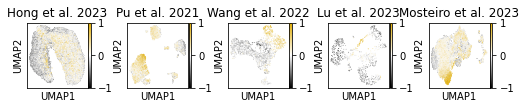

In [110]:
ncols = 5
nrows = 1
figsize = 1.2
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
print((ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize))
plt.subplots_adjust(wspace=wspace)
s = 3
# axes = len(adatas.keys())
# fig, axs = plt.subplots(1,axes, figsize=(15,2.5),constrained_layout=True, subplot_kw=dict(aspect='equal'))

for k, ax in zip(adatas.keys(), axs):
    sc.pl.umap(adatas[k], color=["combined_score01"],legend_fontsize='7',ax=ax, show=False, s=s, cmap=get_continuous_cmap(hex_list), title=titles[k])
    for l in AXS['mainplot_ax'].get_xticklabels():
        l.set_fontsize(8)
    for l in AXS['mainplot_ax'].get_yticklabels():
        l.set_fontsize(8)
plt.savefig('./figures/combined_score.pdf')    

In [112]:
adatas.keys()

dict_keys(['Ho_adata', 'Pu_adata', 'Wa_adata', 'Lu_adata', 'Mo_adata'])

In [113]:
adatas_norm = {}
for k, v in adatas.items():
    adatas[k].X = adatas[k].layers['counts'].copy()
    sc.pp.normalize_total(adatas[k], target_sum=1e4)
    sc.pp.log1p(adatas[k])
    adatas_norm[k] = adatas[k]

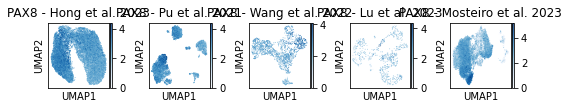

In [121]:
ncols = 5
nrows = 1
figsize = 1.2
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
s = 3
alpha = 0.8
# axes = len(adatas.keys())
# fig, axs = plt.subplots(1,axes, figsize=(15,2.5),constrained_layout=True, subplot_kw=dict(aspect='equal'))
for k, ax in zip(adatas_norm.keys(), axs):
    sc.pl.umap(adatas_norm[k], color=["PAX8"],legend_fontsize='large',ax=ax, show=False, s=s, cmap='Blues', title=f'PAX8 - {titles[k]}', alpha=alpha)
    for l in AXS['mainplot_ax'].get_xticklabels():
        l.set_fontsize(8)
    for l in AXS['mainplot_ax'].get_yticklabels():
        l.set_fontsize(8)
plt.savefig('./figures/PAX8.pdf')    

In [20]:
import marsilea as ma
import marsilea.plotter as mp

In [21]:
colors = {'fTFC1': '#1B758F',
          'fTFC2': '#42BCC9',
          'ambiguous': 'grey'}

In [22]:
dfs = []
for k, v in adatas.items():
    v.obs['label_cs'] = 'ambiguous'
    v.obs.loc[v.obs['combined_score01'] >  0.1, 'label_cs'] = 'fTFC2'
    v.obs.loc[v.obs['combined_score01'] < -0.1, 'label_cs'] = 'fTFC1'
    temp = pd.DataFrame(v.obs['label_cs'].rename(titles[k]).value_counts())
    dfs.append(temp)
df2plot = pd.concat(dfs, axis=1)
df2plot

,Hong et al. 2023,Pu et al. 2021,Wang et al. 2022,Lu et al. 2023,Mosteiro et al. 2023
fTFC1,13911,2469,877,558,9777
ambiguous,3894,1900,336,116,5199
fTFC2,1326,1655,433,80,2816


In [131]:
df2plot.sum()

Hong et al. 2023        19131
Pu et al. 2021           6024
Wang et al. 2022         1646
Lu et al. 2023            754
Mosteiro et al. 2023    17792
dtype: int64

In [156]:
# get percent 
dic = '{:.2f}'
df_percent = df2plot / df2plot.sum() * 100
print(f"fTFC1 %: {dic.format(df_percent.loc['fTFC1'].min())}% - {dic.format(df_percent.loc['fTFC1'].max())}%")
print(f"fTFC2 %: {dic.format(df_percent.loc['fTFC2'].min())}% - {dic.format(df_percent.loc['fTFC2'].max())}%")

fTFC1 %: 40.99% - 74.01%
fTFC2 %: 6.93% - 27.47%


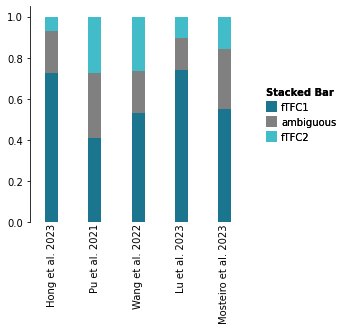

In [23]:
bar = mp.StackBar(df2plot / df2plot.sum(), width=0.3, legend_kws=dict(title="Stacked Bar"), colors=colors)
wb = ma.WhiteBoard(width=3, height=3, margin=0.1)
sample_name = mp.Labels(df2plot.columns)
wb.add_layer(bar)
wb.add_legends()
wb.add_bottom(sample_name)
wb.set_margin(0.1)
wb.render()
plt.savefig('./figures/barplots.pdf')    

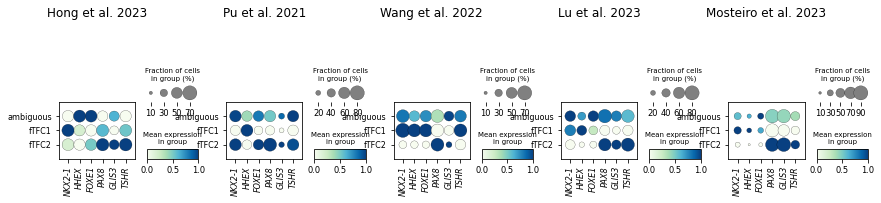

In [77]:
ncols = 5
nrows = 1
figsize = 2.5
wspace = 0.2
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
for k, ax in zip(adatas.keys(), axs):
    AXS = sc.pl.dotplot(adatas[k], cmap='GnBu', groupby='label_cs', var_names=gg, standard_scale='var', title=titles[k], ax=ax, show=False)
    for l in AXS['mainplot_ax'].get_xticklabels():
        l.set_style('italic')
        l.set_fontsize(8)
    for l in AXS['mainplot_ax'].get_yticklabels():
        l.set_fontsize(8)
    AXS['size_legend_ax'].title.set_fontsize(7)
    AXS['color_legend_ax'].title.set_fontsize(7)
plt.savefig('./figures/dotplots.pdf')    